In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import os

In [13]:
# Load data
train = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction training (with labels).csv')
test  = pd.read_csv('../input/tcdml1920-income-ind/tcd ml 2019-20 income prediction test (without labels).csv')

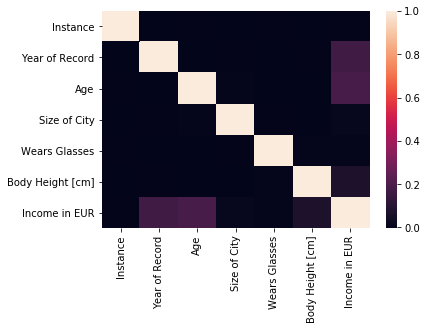

In [14]:
corrmat = train.corr()
sns.heatmap(corrmat);

In [15]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
Gender,7432,6.64
University Degree,7370,6.58
Hair Color,7242,6.47
Age,494,0.44
Year of Record,441,0.39
Profession,322,0.29


In [57]:
all_data = pd.concat((train.loc[:, 'Year of Record': 'Body Height [cm]'],
                      test.loc[:, 'Year of Record': 'Body Height [cm]']))

In [58]:
all_data.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)
train.rename(columns={ 'Body Height [cm]': 'Height' }, inplace=True)

all_data = all_data.replace({ 'Gender': { '0' : np.nan, 'unknown': np.nan } })
all_data = all_data.replace({ 'University Degree': { '0' : 'No', '#NaN': np.nan } })
all_data = all_data.replace({ 'Hair Color': { '0': np.nan, 'Unknown': np.nan } })

In [59]:
log_income = np.log1p(train['Income in EUR'])
log_income = log_income.fillna(0)
y = log_income

all_data = all_data.fillna(all_data.median())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [60]:

categorical_feats = train.select_dtypes(include = ["object"]).columns

for cat in categorical_feats:
    all_data[cat] = all_data[cat].fillna(all_data[cat].value_counts().index[0])

In [61]:
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

stdSc = StandardScaler()
all_data.loc[:, numeric_feats] = stdSc.fit_transform(all_data.loc[:, numeric_feats])

In [62]:
all_data.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Height
0,-0.212657,male,0.232257,Belarus,0.188299,steel workers,Bachelor,-1.001226,Blond,0.895147
1,-0.299233,other,0.232257,Singapore,0.356937,safe event coordinator,Master,-1.001226,Black,0.543422
2,1.605453,other,-0.582018,Norway,0.215242,receivables/payables analyst,PhD,0.998775,Brown,-0.260520
3,0.566533,other,-0.268836,Cuba,-0.038063,fleet assistant,No,0.998775,Black,-0.210274
4,0.912840,female,0.545439,United Arab Emirates,-0.342575,lead trainer,No,-1.001226,Blond,0.643915


In [65]:
from category_encoders import TargetEncoder

target_enc = TargetEncoder(cols=['Profession']).fit(train.loc[:, 'Year of Record':'Height'], y = train['Income in EUR'])
all_data = target_enc.transform(all_data.reset_index(drop=True))

le = preprocessing.LabelEncoder()
all_data['Country'] = le.fit_transform(all_data['Country'])

In [66]:
all_data = pd.get_dummies(all_data, columns = ['University Degree', 'Hair Color', 'Gender'])

In [67]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = log_income

In [72]:
all_data['Profession'].unique()

array([109213.80778058])

In [46]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=200)

regr.fit(X_train, train['Income in EUR'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [47]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, train['Income in EUR'], scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

rmse_cv(regr).mean()

142975.11738108727